# Unconfined steady-state flow model

This tutorial demonstrates a simple MODFLOW 6 model with FloPy.

## Getting Started

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import flopy

We are creating a square model with a specified head equal to `h1` along
the edge of the model in layer 1. A well is located in the center of the
upper-left quadrant in layer 10. First, set the name of the model and
the parameters of the model: the number of layers `Nlay`, the number of
rows and columns `N`, lengths of the sides of the model `L`, aquifer
thickness `H`, hydraulic conductivity `k`, and the well pumping rate `q`.

In [4]:
h1 = 100
Nlay = 10
N = 101
L = 400.0
H = 50.0
k = 1.0
q = -1000.0

### Create the Flopy Model Objects

One big difference between MODFLOW 6 and previous MODFLOW versions is
that MODFLOW 6 is based on the concept of a simulation.
A simulation consists of the following:

* Temporal discretization (`TDIS`)
* One or more models
* Zero or more exchanges (instructions for how models are coupled)
* Solutions

For this simple example, the simulation consists of the temporal
discretization (`TDIS`) package, a groundwater flow (`GWF`) model, and
an iterative model solution (`IMS`), which controls how the GWF model is
solved.

### Create a temporary workspace, then the FloPy simulation object

In [5]:
temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name)
name = "tutorial01_mf6"
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace
)

### Create the Flopy `TDIS` object

In [6]:
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

### Create the Flopy `IMS` Package object

In [7]:
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    complexity="SIMPLE",
    linear_acceleration="BICGSTAB",
)

Create the Flopy groundwater flow (gwf) model object

In [8]:
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    model_nam_file=model_nam_file,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)

Now that the overall simulation is set up, we can focus on building the
groundwater flow model. The groundwater flow model will be built by
adding packages to it that describe the model characteristics.

### Create the discretization (`DIS`) Package

Define the discretization of the model. All layers are given equal thickness.
The `bot` array is build from `H` and the `Nlay` values to indicate top and
bottom of each layer, and `delrow` and `delcol` are computed from model
size `L` and number of cells `N`. Once these are all computed, the
Discretization file is built.

In [9]:
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

### Create the initial conditions (`IC`) Package

In [10]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

### Create the node property flow (`NPF`) Package

In [11]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=1,
    k=k,
)

### Create the constant head (`CHD`) Package

List information is created a bit differently for MODFLOW 6 than for other
MODFLOW versions. The cellid (layer, row, column, for a regular grid)
can be entered as a tuple as the first entry. Remember that these must be
zero-based indices!

In [12]:
chd_rec = []
layer = 0
for row_col in range(0, N):
    chd_rec.append(((layer, row_col, 0), h1))
    chd_rec.append(((layer, row_col, N - 1), h1))
    if row_col != 0 and row_col != N - 1:
        chd_rec.append(((layer, 0, row_col), h1))
        chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_rec,
)

The `CHD` Package stored the constant heads in a structured array,
also called a `numpy.recarray`. We can get a pointer to the recarray
for the first stress period (iper = 0) as follows.

In [13]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((0, 0, 0), 100), ((0, 0, 100), 100), ((0, 1, 0), 100),
           ((0, 1, 100), 100), ((0, 0, 1), 100), ((0, 100, 1), 100),
           ((0, 2, 0), 100), ((0, 2, 100), 100), ((0, 0, 2), 100),
           ((0, 100, 2), 100), ((0, 3, 0), 100), ((0, 3, 100), 100),
           ((0, 0, 3), 100), ((0, 100, 3), 100), ((0, 4, 0), 100),
           ((0, 4, 100), 100), ((0, 0, 4), 100), ((0, 100, 4), 100),
           ((0, 5, 0), 100), ((0, 5, 100), 100), ((0, 0, 5), 100),
           ((0, 100, 5), 100), ((0, 6, 0), 100), ((0, 6, 100), 100),
           ((0, 0, 6), 100), ((0, 100, 6), 100), ((0, 7, 0), 100),
           ((0, 7, 100), 100), ((0, 0, 7), 100), ((0, 100, 7), 100),
           ((0, 8, 0), 100), ((0, 8, 100), 100), ((0, 0, 8), 100),
           ((0, 100, 8), 100), ((0, 9, 0), 100), ((0, 9, 100), 100),
           ((0, 0, 9), 100), ((0, 100, 9), 100), ((0, 10, 0), 100),
           ((0, 10, 100), 100), ((0, 0, 10), 100), ((0, 100, 10), 100),
           ((0, 11, 0), 100), ((0, 11, 100),

### Create the well (`WEL`) Package

Add a well in model layer 10.

In [14]:
wel_rec = [(Nlay - 1, int(N / 4), int(N / 4), q)]
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_rec,
)

### Create the output control (`OC`) Package

Save heads and budget output to binary files and print heads to the model
listing file at the end of the stress period.

In [15]:
headfile = f"{name}.hds"
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

## Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create
all of the input files and run the model.

### Write the datasets

In [16]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model tutorial01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 400 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data


    writing package oc...


### Run the Simulation

We can also run the simulation from python, but only if the MODFLOW 6
executable is available.  The executable can be made available by putting
the executable in a folder that is listed in the system path variable.
Another option is to just put a copy of the executable in the simulation
folder, though this should generally be avoided. A final option is to
provide a full path to the executable when the simulation is constructed.
This would be done by specifying exe_name with the full path.

In [17]:
success, buff = sim.run_simulation()
assert success, "MODFLOW 6 did not terminate normally."

FloPy is using the following executable to run the model: ../../home/runner/.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 19 2024 14:19:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/17  0:57:01
 Elapsed run time:  1.802 Seconds
 
 Normal termination of simulation.


## Post-Process Head Results

First, a link to the heads file is created with using the `.output.head()` method on the groundwater flow model. The link and the `get_data` method are used with the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

Read the binary head file and plot the results. We can use the Flopy
`.output.head()` method on the groundwater flow model object (`gwf`).
Also set a few variables that will be used for plotting.


In [18]:
h = gwf.output.head().get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
y = y[::-1]
vmin, vmax = 90.0, 100.0
contour_intervals = np.arange(90, 100.1, 1.0)

### Plot a Map of Layer 1

<a list of 6 text.Text objects>

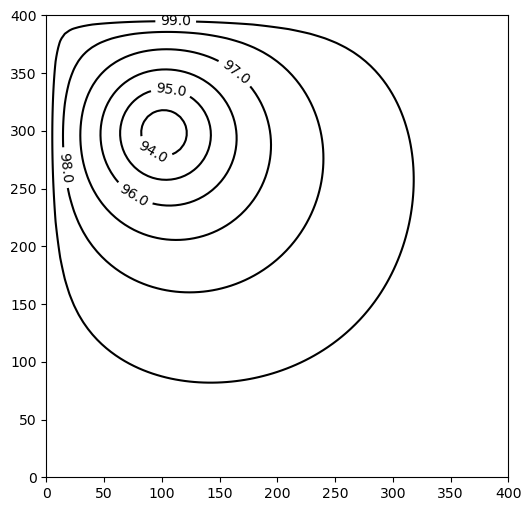

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.clabel(c, fmt="%2.1f")

### Plot a Map of Layer 10

<a list of 11 text.Text objects>

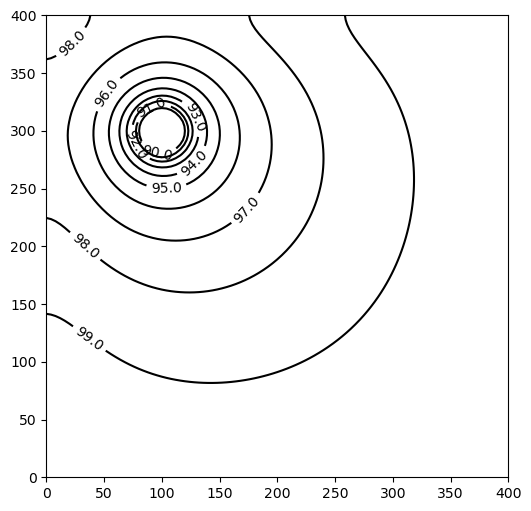

In [20]:
x = y = np.linspace(0, L, N)
y = y[::-1]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[-1], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")

### Plot a Cross-section along row 25

<a list of 15 text.Text objects>

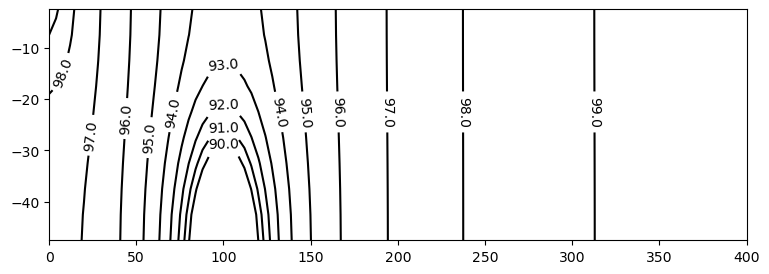

In [21]:
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(x, z, h[:, int(N / 4), :], contour_intervals, colors="black")
plt.clabel(c, fmt="%1.1f")

### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

### Plot a Map of heads in Layers 1 and 10

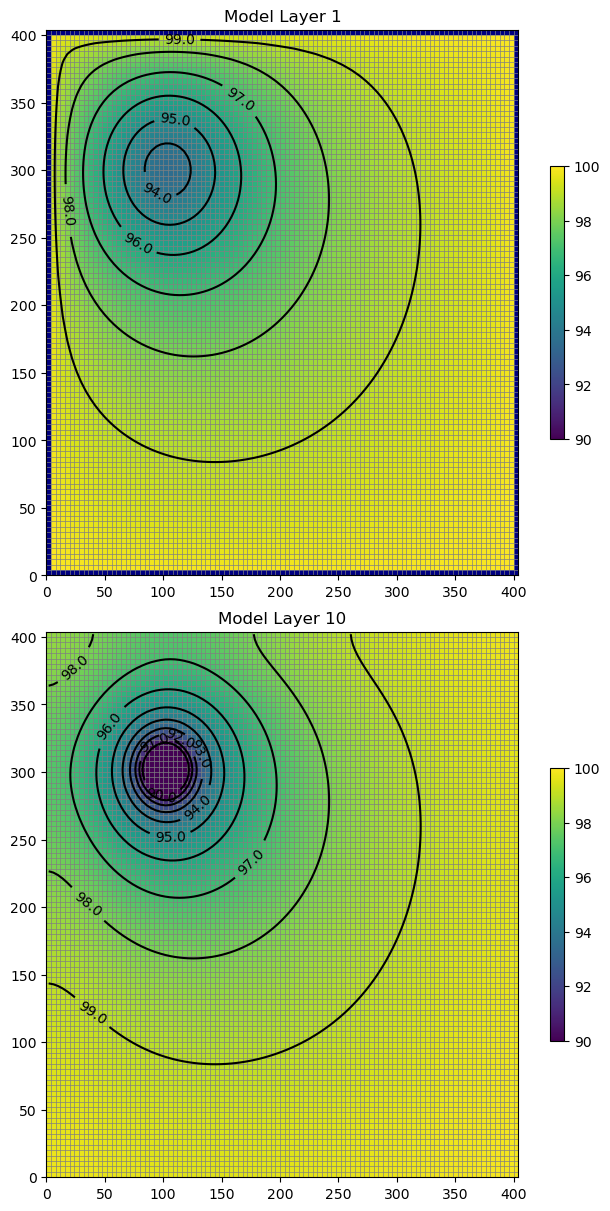

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(6, 12), constrained_layout=True)
# first subplot
ax = axes[0]
ax.set_title("Model Layer 1")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)
# second subplot
ax = axes[1]
ax.set_title(f"Model Layer {Nlay}")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

### Use the FloPy `PlotCrossSection()` capabilities for MODFLOW 6

### Plot a cross-section of heads along row 25

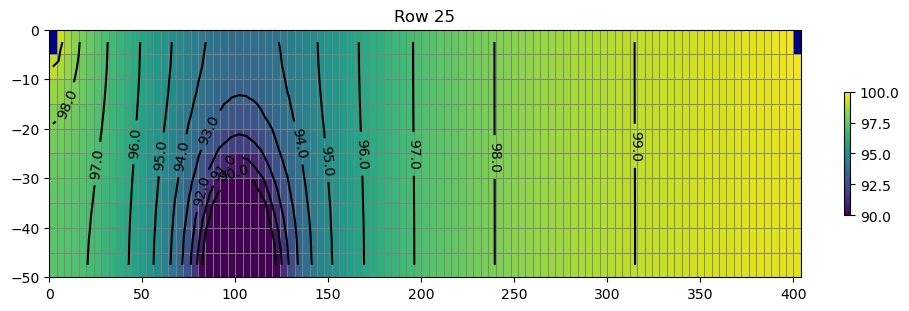

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
# first subplot
ax.set_title("Row 25")
modelmap = flopy.plot.PlotCrossSection(
    model=gwf,
    ax=ax,
    line={"row": int(N / 4)},
)
pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
cb = plt.colorbar(pa, shrink=0.5, ax=ax)

## Determine the Flow Residual

The `FLOW-JA-FACE` cell-by-cell budget data can be processed to
determine the flow residual for each cell in a MODFLOW 6 model. The
diagonal position for each row in the `FLOW-JA-FACE` cell-by-cell
budget data contains the flow residual for each cell and can be
extracted using the `flopy.mf6.utils.get_residuals()` function.

First extract the `FLOW-JA-FACE` array from the cell-by-cell budget file

In [24]:
flowja = gwf.oc.output.budget().get_data(text="FLOW-JA-FACE", kstpkper=(0, 0))[
    0
]

Next extract the flow residual. The MODFLOW 6 binary grid file is passed
into the function because it contains the ia array that defines
the location of the diagonal position in the `FLOW-JA-FACE` array.

In [25]:
grb_file = workspace / f"{name}.dis.grb"
residual = flopy.mf6.utils.get_residuals(flowja, grb_file=grb_file)

### Plot a Map of the flow error in Layer 10

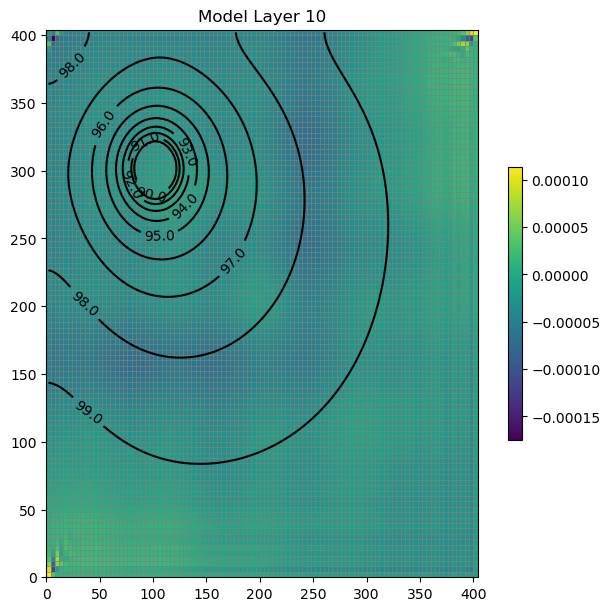

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
ax.set_title("Model Layer 10")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=Nlay - 1)
pa = modelmap.plot_array(residual)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")
plt.colorbar(pa, shrink=0.5)

Clean up the temporary directory

In [27]:
try:
    temp_dir.cleanup()
except PermissionError:
    # can occur on windows: https://docs.python.org/3/library/tempfile.html#tempfile.TemporaryDirectory
    pass